<a href="https://colab.research.google.com/github/garrett-vangilder/CS5262/blob/main/fema_declarations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Future Frequency of Disasters by State

## Background

Extreme weather events are becoming more likely as the effects of climate change are realized. This can be seen in the plethora of wildfires throughout the West. The Federal Emergency Management Agency (FEMA) does not declare every extreme weather event a disaster, but through a workflow specified by the Stafford Act, state and federal leaders can work together to determine if federal aid is necessary. The type of aid given to individuals is broad. It can include financial gifts to individuals or small businesses with the intention of using the funds for temporary housing or repairs.

Is it possible to use [historical FEMA declarations](https://www.kaggle.com/datasets/headsortails/us-natural-disaster-declarations) to determine the change in frequency of catastrophic weather events for a given state? Are catastrophic weather events becoming more prevalent?

## Project Description

Using historical FEMA disaster records, researchers can determine the likelihood of future disasters and disaster types when given a date and a state location. This could be useful in analyzing changes to local and federal funding for extreme weather events. This research can potentially be used as a proxy for defining the financial repercussions of climate change. When paired with a municipalities budget and other financial records, this data could help decide if funds are over or under-provisioned for disaster relief. Federal governments could extrapolate this data to inform federal funding better. There may even be a case for private real estate development firms to use this model when selecting the viability of significant projects for a given location. If developers are aware that there is a high likelihood of volatile weather throughout a given month range, then a developer may determine that it is best to start their project in a different month to prevent delays to their timeline.

The overall goal of this model is to be used as an severe weather predictor by volume for states.

## Performance Metrics

We will analyze the performance of this regression model through the mean squared error metric. This model will be considered a success if the prediction is within +/- 2 events for most states. To validate the model we will create a training dataset of all events before 2022, our test dataset will include the complete dataset, meaning that we will include 2022 disasters. 

## Exploratory Data Analysis

Through my initial exploratory data analysis, I am looking to answer the following questions to understand my dataset better.

1. Are all states represented, and if so which state is most prone to disasters?

2. Are disasters becoming more or less common? How many disasters are there each year?

3. What are the most common disaster types?

4. Are there any correlated variables in my dataset? 

In [2]:
# Load commons libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

#### Load Data

We will injest our dataset, and the data dictionary.

Data was initially sourced from FEMA, however it has been made public via [kaggle](https://www.kaggle.com/datasets/headsortails/us-natural-disaster-declarations)

We wil source our data from a clone located in the corresponding [github repo](https://github.com/garrett-vangilder/CS5262).

In [33]:
data_dictionary = pd.read_csv('https://raw.githubusercontent.com/garrett-vangilder/CS5262/main/data_dictionary.csv')

disasters = pd.read_csv('https://raw.githubusercontent.com/garrett-vangilder/CS5262/main/us_disaster_declarations.csv')


#### Data Dictionary

In [ ]:
display(data_dictionary)

,feature,description,type
0,fema_declaration_string,codified identifier for disaster - declaration...,string
1,disaster_number,an incremented value used to designate an event,integer
2,state,US state or territory - formatted as XX,string
3,declaration_type,"DR(""major disaster"") or EM(""emergency manageme...",string
4,declaration_date,date of disaster declaration formatted YYYY-MM...,datetime
5,fy_declared,fiscal year of declaration formatted YYYY,integer
6,incident_type,"classification of incident type example: ""Floo...",integer
7,declaration_title,generic identifier for incident typically huma...,string
8,ih_program_declared,"boolean value denotes if the ""Individual and H...",boolean
9,ia_program_declared,"boolean value denotes if the ""Individual Assis...",boolean


#### 1. Are all states represented, and if so which state is most prone to disasters?

In [ ]:
disasters.groupby('state').fema_declaration_string.nunique().sort_values(ascending=False)


state
TX    371
CA    357
OK    218
WA    191
FL    168
OR    140
NM    111
NY    107
AZ    106
LA    101
CO    101
NV    100
AL     99
MT     98
MS     90
SD     87
KY     86
TN     83
KS     82
AR     79
MO     77
MN     77
AK     77
NE     76
WV     75
NC     73
IA     73
GA     72
VA     72
ND     67
IL     64
PA     63
ME     63
HI     61
OH     59
NJ     57
NH     57
MA     56
WI     54
ID     53
VT     52
UT     51
IN     51
PR     46
MI     43
CT     39
SC     38
WY     38
MD     37
VI     30
RI     27
DE     25
DC     23
MP     23
FM     21
GU     19
AS     16
MH      7
PW      1
Name: fema_declaration_string, dtype: int64

In [ ]:
len(disasters.groupby('state'))

59

All states are represented in the dataset, however it seems that there are multiple rows per unique incident, moving forward all queries will filter data for unique entries by FEMA declaration string.

#### 2. Are disasters becoming more or less common? How many disasters are there each year?

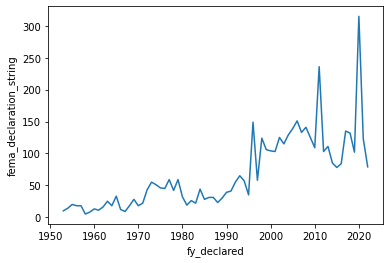

In [ ]:
disaster_count_by_year = disasters.groupby('fy_declared').fema_declaration_string.nunique().sort_index()
sns.lineplot(data=disaster_count_by_year);

In [ ]:
disaster_count_by_year.mean()

66.97142857142858

It seems that there are generally more FEMA incidents in the recent future compared to past events. 

#### 3. What are the most common disaster types?


In [ ]:
disasters.groupby('incident_type').fema_declaration_string.nunique().sort_values(ascending=False)

incident_type
Fire                1542
Severe Storm(s)     1017
Flood                853
Hurricane            425
Tornado              177
Snow                 169
Biological           167
Severe Ice Storm      74
Typhoon               58
Drought               46
Earthquake            35
Other                 31
Coastal Storm         31
Freezing              18
Mud/Landslide          9
Toxic Substances       8
Fishing Losses         6
Dam/Levee Break        6
Volcano                6
Human Cause            4
Tsunami                3
Terrorist              2
Chemical               1
Name: fema_declaration_string, dtype: int64

Natural disasters seem to be the most common disaster, however it is interesting to note that there are chemical, terrorist, and generally human-centric disasters that do qualify for FEMA assistance. 

#### 4. Are there any correlated variables in my dataset?

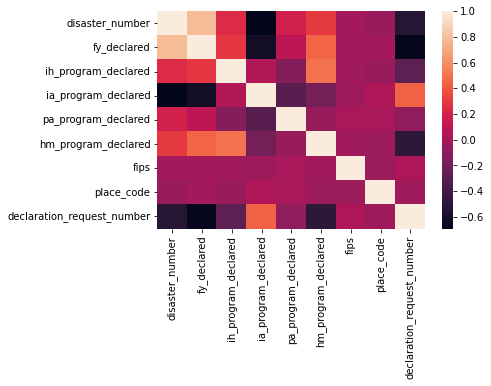

In [ ]:
sns.heatmap(disasters.corr())

`disaster_number` and `fy_declaraed` correspond, this is not a surprise since `disaster_number` increments, as do years. 

## Feature engineering

Due to the nature of our dataset, we will need to perform some transformations to better train our model. We are interested in disasters that are weather related, meaning we will also need to perform some operations to clean or remove rows from our dataset. 

We will remove rows with the following `incident_type`
1. Biological
2. Toxic Substance
3. Human Cause
4. Terrorist
5. Chemical

We will maintain `Fishing Losses` and `Dam/Levee Break` since they theoretically could be caused by extreme weather patterns. Human cause via climate migration is also outside the scope of this model. 

Disasters that persist over a larger time period are over valued in this model, we are not looking into the length of a model but instead we are interested in unique events. Because of this we will enforce a uniqueness to `fema_declaration_string` meaning that only the initial row for a declaration string will be used. 

`season` will be added - this will be specific to the `incident_begin_date` and for simplicities sake follow the 2022 seasonale calendar

- Winter: Jan 1 - March 19 / Dec 21 - Dec 31
- Spring: March 20 - June 21
- Summer: June 22 - Sept 21
- Fall: Sept 22 - Dec 20


In [34]:
# Drop non weather specific events
it_to_drop = ['Biological', 'Toxic Substance', 'Human Cause', 'Terrorist', 'Chemical']

disasters = disasters[~disasters.incident_type.isin(it_to_drop)]


In [35]:
# Drop all but first entry by fema_declaration_string

disasters = disasters.drop_duplicates(subset=['fema_declaration_string'])

In [36]:
# Add seasons
WINTER = 'winter'
SPRING = 'spring'
SUMMER = 'summer'
FALL = 'fall'

month_to_seasons = {
    1: WINTER,
    2: WINTER,
    3: SPRING,
    4: SPRING,
    5: SPRING,
    6: SUMMER,
    7: SUMMER,
    8: SUMMER,
    9: FALL,
    10: FALL,
    11: FALL,
    12: WINTER
}
disasters['declaration_date'] = pd.to_datetime(disasters.declaration_date, format='%Y-%m-%d %H:%M:%S')
disasters['month'] = disasters['declaration_date'].dt.month
disasters['season'] = disasters.month.apply(lambda month: month_to_seasons.get(month))

In [37]:
# Drop unrelated columns

disasters = disasters.drop(
    columns=['ih_program_declared','ia_program_declared',
             'pa_program_declared','hm_program_declared', 
             'last_ia_filing_date', 'hash', 'id', 'last_refresh',
             'month']
)

In [38]:
disasters

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,incident_begin_date,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number,season
0,DR-1-GA,1,GA,DR,1953-05-02 00:00:00+00:00,1953,Tornado,Tornado,1953-05-02T00:00:00Z,1953-05-02T00:00:00Z,1954-06-01T00:00:00Z,13000,0,Statewide,53013,spring
1,DR-2-TX,2,TX,DR,1953-05-15 00:00:00+00:00,1953,Tornado,Tornado & Heavy Rainfall,1953-05-15T00:00:00Z,1953-05-15T00:00:00Z,1958-01-01T00:00:00Z,48000,0,Statewide,53003,spring
2,DR-3-LA,3,LA,DR,1953-05-29 00:00:00+00:00,1953,Flood,Flood,1953-05-29T00:00:00Z,1953-05-29T00:00:00Z,1960-02-01T00:00:00Z,22000,0,Statewide,53005,spring
3,DR-4-MI,4,MI,DR,1953-06-02 00:00:00+00:00,1953,Tornado,Tornado,1953-06-02T00:00:00Z,1953-06-02T00:00:00Z,1956-02-01T00:00:00Z,26000,0,Statewide,53004,summer
4,DR-5-MT,5,MT,DR,1953-06-06 00:00:00+00:00,1953,Flood,Floods,1953-06-06T00:00:00Z,1953-06-06T00:00:00Z,1955-12-01T00:00:00Z,30000,0,Statewide,53006,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63183,FM-5447-WA,5447,WA,FM,2022-08-04 00:00:00+00:00,2022,Fire,Lind Fire,2022-08-04T00:00:00Z,NaN,NaN,53001,99001,Adams (County),22068,summer
63184,DR-4665-MO,4665,MO,DR,2022-08-08 00:00:00+00:00,2022,Flood,Severe Storms And Flooding,2022-07-25T00:00:00Z,2022-07-28T00:00:00Z,NaN,29139,99139,Montgomery (County),22067,summer
63188,DR-4666-MN,4666,MN,DR,2022-08-09 00:00:00+00:00,2022,Severe Storm(s),"Severe Storms, Straight-Line Winds, Tornadoes,...",2022-05-29T00:00:00Z,2022-05-30T00:00:00Z,NaN,27115,99115,Pine (County),22062,summer
63211,FM-5448-NV,5448,NV,FM,2022-08-14 00:00:00+00:00,2022,Fire,Joy Lake Fire,2022-08-14T00:00:00Z,NaN,NaN,32031,99031,Washoe (County),22070,summer


## Train test split

based on the metadata (such as size
and target class distribution) of your dataset, briefly outline your train/test percent split. Include the percentage for your golden holdout set if you plan to leave one out

## Establish an initial pipeline

briefly describe the
pipes you may need

## Model fitting and evaluation

list 1-3 assumptions you have about feature importance or how you anticipate your model’s performance will be